# Inference with SR3 with temporal features

Notebook similar to the regular inference script used for all other models. However, the pre-generated temporal features also have to be considered during inference, thus some adaptions were required, which is why a seperate notebook has been created.

Imports

In [1]:
#!pip install tensorboardX

In [2]:
import torch
import argparse
import logging
#from tensorboardX import SummaryWriter
import os
import numpy as np

from io import BytesIO
from PIL import Image
from torch.utils.data import Dataset
import random
from re import split
import torch.utils.data

# import torch.nn as nn
from collections import OrderedDict

import functools
from torch.nn import init
from torch.nn import modules

# u-net
import math
import torch.nn.functional as F
from inspect import isfunction

# diffusion
from torch import nn
from functools import partial
from tqdm import tqdm

Config

In [3]:
opt = {
    "name": "denoising",
    "phase": "test", # train or test (or val?? -> what is phase even used for also?)
    "gpu_ids": [0, 1], 
    "debug": False,  
    "enable_wandb": False,  
    "log_wandb_ckpt": False,  
    "log_eval": False,  
    "path": {
        "log": "/kaggle/working/logs",
        "tb_logger": "/kaggle/working/tb_logger",
        "results": "/kaggle/working/results",
        "checkpoint": "/kaggle/working/checkpoint",
        "resume_state": "/kaggle/input/sr3_temp_v5/pytorch/default/1/checkpoint/I27900_E31"
    },
    "datasets": {
        "train": {
            "noisy_data_paths": ['/kaggle/input/fmri-train-1-norm-v3/data/noisy_func_train_1.npy',
                '/kaggle/input/fmri-train-2-norm-v3/data/noisy_func_train_2.npy',
                '/kaggle/input/fmri-train-3-norm-v3/data/noisy_func_train_3.npy'],
            "gt_data_paths": ['/kaggle/input/fmri-train-1-norm-v3/data/gt_func_train_1.npy',
                '/kaggle/input/fmri-train-2-norm-v3/data/gt_func_train_2.npy',
                '/kaggle/input/fmri-train-3-norm-v3/data/gt_func_train_3.npy'],
            "batch_size": 1,
            "num_workers": 1,
            "use_shuffle": True
        },
        "test": {
            "noisy_data_paths": ['/kaggle/input/fmri-test-norm-v3/data/noisy_func_test.npy'],
            "gt_data_paths": ['/kaggle/input/fmri-test-norm-v3/data/gt_func_test.npy'],
            "temp_feature_paths":["/kaggle/input/temporal-features-test/temporal_features_1.npy"
            ]
        }
    },
    "model": {
        "which_model_G": "sr3",
        "finetune_norm": False,
        "unet": {
            "in_channel": 2,
            "out_channel": 1,
            "inner_channel": 64,
            "norm_groups": 16,
            "channel_multiplier": [1, 2, 4, 4, 8],
            "attn_res": [],
            "res_blocks": 1,
            "dropout": 0
        },
        "beta_schedule": {
            "train": {
                "schedule": "linear",
                "n_timestep": 2000,
                "linear_start": 1e-6,
                "linear_end": 1e-2
            },
            "test": {
                "schedule": "linear",
                "n_timestep": 2000,
                "linear_start": 1e-6,
                "linear_end": 1e-2
            }
        },
        "diffusion": {
            "image_size": 64,
            "channels": 1,
            "conditional": True
        }
    },
    "train": {
        "n_iter": 8100,
        "val_freq": 1e4,
        "save_checkpoint_freq": 2700,
        "print_freq": 100,
        "optimizer": {
            "type": "adam",
            "lr": 3e-4
        },
        "ema_scheduler": {
            "step_start_ema": 22500,
            "update_ema_every": 1,
            "ema_decay": 0.996
        }
    },
    "wandb": {
        "project": "distributed_high_sr_ffhq"
    },
    "config_file": "config/sr_sr3_16_128.json"  # from CLI
}

In [4]:
os.makedirs(opt['path']['log'], exist_ok=True)
os.makedirs(opt['path']['tb_logger'], exist_ok=True)
os.makedirs(opt['path']['results'], exist_ok=True)
os.makedirs(opt['path']['checkpoint'], exist_ok=True)
#os.makedirs(opt['path']['resume_state'], exist_ok=True)

Logger

In [5]:
# logging
torch.backends.cudnn.enabled = True
torch.backends.cudnn.benchmark = True

def dict2str(opt, indent_l=1):
    '''dict to string for logger'''
    msg = ''
    for k, v in opt.items():
        if isinstance(v, dict):
            msg += ' ' * (indent_l * 2) + k + ':[\n'
            msg += dict2str(v, indent_l + 1)
            msg += ' ' * (indent_l * 2) + ']\n'
        else:
            msg += ' ' * (indent_l * 2) + k + ': ' + str(v) + '\n'
    return msg

def setup_logger(logger_name, root, phase, level=logging.INFO, screen=False):
    '''set up logger'''
    l = logging.getLogger(logger_name)
    formatter = logging.Formatter(
        '%(asctime)s.%(msecs)03d - %(levelname)s: %(message)s', datefmt='%y-%m-%d %H:%M:%S')
    log_file = os.path.join(root, '{}.log'.format(phase))
    fh = logging.FileHandler(log_file, mode='w')
    fh.setFormatter(formatter)
    l.setLevel(level)
    l.addHandler(fh)
    if screen:
        sh = logging.StreamHandler()
        sh.setFormatter(formatter)
        l.addHandler(sh)


setup_logger(None, opt['path']['log'],
                    'train', level=logging.INFO, screen=True)
setup_logger('val', opt['path']['log'], 'val', level=logging.INFO)
logger = logging.getLogger('base')
#logger.info(dict2str(opt))
#tb_logger = SummaryWriter(log_dir=opt['path']['tb_logger'])

# # Initialize WandbLogger
# if opt['enable_wandb']:
#     import wandb
#     wandb_logger = WandbLogger(opt)
#     wandb.define_metric('validation/val_step')
#     wandb.define_metric('epoch')
#     wandb.define_metric("validation/*", step_metric="val_step")
#     val_step = 0
# else:
#     wandb_logger = None

Dataset creation

In [6]:
class PairwiseTestDataset(Dataset):
    def __init__(self, noisy_images_paths: list, gt_images_paths: list):
        """Initialize fMRI dataset for denoising with memory-efficient loading.
        
        Args:
            noisy_images_paths (list): List of paths to noisy fMRI volumes (.npy files)
            gt_images_paths (list): List of paths to ground truth fMRI volumes (.npy files)
        """
        self.noisy_paths = noisy_images_paths
        self.gt_paths = gt_images_paths
        
        # Get the data shape and total slices without loading all data
        # Just load file info and calculate indices
        self.file_slice_mapping = []
        total_slices = 0
        
        for i, path in enumerate(noisy_images_paths):
            # Load metadata about the file shape without loading full content
            data_shape = np.load(path, mmap_mode='r').shape
            num_slices = data_shape[2] * data_shape[3]  # z * t
            
            # Store mapping information: which file and which slice
            for slice_idx in range(num_slices):
                self.file_slice_mapping.append((i, slice_idx))
            
            total_slices += num_slices
            
        self.data_len = total_slices

    def __len__(self):
        return self.data_len

    def __getitem__(self, index):
        # Use the mapping to determine which file and slice to load
        file_idx, slice_idx = self.file_slice_mapping[index]
        
        # Load data from the specific file
        noisy_file_path = self.noisy_paths[file_idx]
        gt_file_path = self.gt_paths[file_idx]
        
        # Load the full 4D array with mmap_mode to avoid loading everything
        noisy_volume = np.load(noisy_file_path, mmap_mode='r')
        gt_volume = np.load(gt_file_path, mmap_mode='r')
        
        # Calculate the z and t indices from linear slice_idx
        z = slice_idx % noisy_volume.shape[2]
        t = slice_idx // noisy_volume.shape[2]
        
        # Extract only the slice we need
        noisy_slice = noisy_volume[:, :, z, t].copy()  # Force copy from mmap
        gt_slice = gt_volume[:, :, z, t].copy()
        
        return {
            'GT': torch.tensor(gt_slice).float().unsqueeze(0),
            'Noisy': torch.tensor(noisy_slice).float().unsqueeze(0),
            'Index': index,
            "z_value": z,
            "t_value": t
        }

In [7]:
# Set a seed for reproducibility
seed = 42
generator = torch.Generator()
generator.manual_seed(seed)

print(f"Random number generator initialized with seed: {seed}")

Random number generator initialized with seed: 42


In [8]:
def collate_merge_batches(batch):
    merged = {
        'Noisy': torch.cat([item['Noisy'] for item in batch], dim=0),
        'GT': torch.cat([item['GT'] for item in batch], dim=0),
        'Index': [item['Index'] for item in batch]
    }
    return merged

def create_dataloader(dataset, dataset_opt, phase):
    '''create dataloader '''
    if phase == 'train':
        return torch.utils.data.DataLoader(
            dataset,
            batch_size=dataset_opt['batch_size'],
            shuffle=dataset_opt['use_shuffle'],
            num_workers=dataset_opt['num_workers'],
            pin_memory=True,
            collate_fn = collate_merge_batches)
    elif phase == 'test':
        return torch.utils.data.DataLoader(
            dataset, batch_size=1, shuffle=True, num_workers=1, pin_memory=True, generator=generator)
    else:
        raise NotImplementedError(
            'Dataloader [{:s}] is not found.'.format(phase))

In [9]:
# dataset
for phase, dataset_opt in opt['datasets'].items():
    if phase == 'train' and opt['phase'] != 'test':
        train_set = PairwiseDataset(dataset_opt['noisy_data_paths'], dataset_opt['gt_data_paths'])
        train_loader = create_dataloader(
            train_set, dataset_opt, phase)
    elif phase == 'test' and opt['phase'] != 'train':
        test_set = PairwiseTestDataset(dataset_opt['noisy_data_paths'], dataset_opt['gt_data_paths'])
        test_loader = create_dataloader(
            test_set, dataset_opt, phase)
# logger.info('Initial Dataset Finished')

## Model loading

Modules

In [10]:
# generic functions
def exists(x):
    return x is not None


def default(val, d):
    if exists(val):
        return val
    return d() if isfunction(d) else d

In [11]:
### U-Net ###

# PositionalEncoding Source： https://github.com/lmnt-com/wavegrad/blob/master/src/wavegrad/model.py
class PositionalEncoding(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, noise_level):
        count = self.dim // 2
        step = torch.arange(count, dtype=noise_level.dtype,
                            device=noise_level.device) / count
        encoding = noise_level.unsqueeze(
            1) * torch.exp(-math.log(1e4) * step.unsqueeze(0))
        encoding = torch.cat(
            [torch.sin(encoding), torch.cos(encoding)], dim=-1)
        return encoding


class FeatureWiseAffine(nn.Module):
    def __init__(self, in_channels, out_channels, use_affine_level=False):
        super(FeatureWiseAffine, self).__init__()
        self.use_affine_level = use_affine_level
        self.noise_func = nn.Sequential(
            nn.Linear(in_channels, out_channels*(1+self.use_affine_level))
        )

    def forward(self, x, noise_embed):
        batch = x.shape[0]
        if self.use_affine_level:
            gamma, beta = self.noise_func(noise_embed).view(
                batch, -1, 1, 1).chunk(2, dim=1)
            x = (1 + gamma) * x + beta
        else:
            x = x + self.noise_func(noise_embed).view(batch, -1, 1, 1)
        return x


class Swish(nn.Module):
    def forward(self, x):
        return x * torch.sigmoid(x)


class Upsample(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.up = nn.Upsample(scale_factor=2, mode="nearest")
        self.conv = nn.Conv2d(dim, dim, 3, padding=1)

    def forward(self, x):
        return self.conv(self.up(x))


class Downsample(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.conv = nn.Conv2d(dim, dim, 3, 2, 1)

    def forward(self, x):
        return self.conv(x)


# building block modules


class Block(nn.Module):
    def __init__(self, dim, dim_out, groups=32, dropout=0):
        super().__init__()
        self.block = nn.Sequential(
            nn.GroupNorm(groups, dim),
            Swish(),
            nn.Dropout(dropout) if dropout != 0 else nn.Identity(),
            nn.Conv2d(dim, dim_out, 3, padding=1)
        )

    def forward(self, x):
        return self.block(x)


class ResnetBlock(nn.Module):
    def __init__(self, dim, dim_out, noise_level_emb_dim=None, dropout=0, use_affine_level=False, norm_groups=32):
        super().__init__()
        self.noise_func = FeatureWiseAffine(
            noise_level_emb_dim, dim_out, use_affine_level)

        self.block1 = Block(dim, dim_out, groups=norm_groups)
        self.block2 = Block(dim_out, dim_out, groups=norm_groups, dropout=dropout)
        self.res_conv = nn.Conv2d(
            dim, dim_out, 1) if dim != dim_out else nn.Identity()

    def forward(self, x, time_emb):
        b, c, h, w = x.shape
        h = self.block1(x)
        h = self.noise_func(h, time_emb)
        h = self.block2(h)
        return h + self.res_conv(x)


class SelfAttention(nn.Module):
    def __init__(self, in_channel, n_head=1, norm_groups=32):
        super().__init__()

        self.n_head = n_head

        self.norm = nn.GroupNorm(norm_groups, in_channel)
        self.qkv = nn.Conv2d(in_channel, in_channel * 3, 1, bias=False)
        self.out = nn.Conv2d(in_channel, in_channel, 1)

    def forward(self, input):
        batch, channel, height, width = input.shape
        n_head = self.n_head
        head_dim = channel // n_head

        norm = self.norm(input)
        qkv = self.qkv(norm).view(batch, n_head, head_dim * 3, height, width)
        query, key, value = qkv.chunk(3, dim=2)  # bhdyx

        attn = torch.einsum(
            "bnchw, bncyx -> bnhwyx", query, key
        ).contiguous() / math.sqrt(channel)
        attn = attn.view(batch, n_head, height, width, -1)
        attn = torch.softmax(attn, -1)
        attn = attn.view(batch, n_head, height, width, height, width)

        out = torch.einsum("bnhwyx, bncyx -> bnchw", attn, value).contiguous()
        out = self.out(out.view(batch, channel, height, width))

        return out + input


class ResnetBlocWithAttn(nn.Module):
    def __init__(self, dim, dim_out, *, noise_level_emb_dim=None, norm_groups=32, dropout=0, with_attn=False):
        super().__init__()
        self.with_attn = with_attn
        self.res_block = ResnetBlock(
            dim, dim_out, noise_level_emb_dim, norm_groups=norm_groups, dropout=dropout)
        if with_attn:
            self.attn = SelfAttention(dim_out, norm_groups=norm_groups)

    def forward(self, x, time_emb):
        x = self.res_block(x, time_emb)
        if(self.with_attn):
            x = self.attn(x)
        return x


class PerPositionFusionLinear(nn.Module):
    def __init__(self, in1_channels, in2_channels, out_channels, height, width, activation=nn.GELU()):
        super().__init__()
        self.h = height
        self.w = width
        self.in_channels = in1_channels + in2_channels
        self.out_channels = out_channels
        self.activation = activation

        # One Linear layer per spatial location
        self.linears = nn.ModuleList([
            nn.Linear(self.in_channels, out_channels)
            for _ in range(height * width)
        ])

    def forward(self, x, external):
        B, C1, H, W = x.shape
        C2 = external.shape[1]
        assert H == self.h and W == self.w
        assert external.shape == (B, C2, H, W)

        fused = torch.cat([x, external], dim=1)  # [B, C1+C2, H, W]
        fused = fused.permute(0, 2, 3, 1).reshape(B, H * W, self.in_channels)

        out = torch.stack([
            self.activation(self.linears[i](fused[:, i]))
            for i in range(H * W)
        ], dim=1)  # [B, H*W, out_channels]

        out = out.permute(0, 2, 1).reshape(B, self.out_channels, H, W)
        return out



class UNet(nn.Module):
    def __init__(
        self,
        in_channel=6,
        out_channel=3,
        inner_channel=32,
        norm_groups=32,
        channel_mults=(1, 2, 4, 8, 8),
        attn_res=(8),
        res_blocks=3,
        dropout=0,
        with_noise_level_emb=True,
        image_size=128
    ):
        super().__init__()

        if with_noise_level_emb:
            noise_level_channel = inner_channel
            self.noise_level_mlp = nn.Sequential(
                PositionalEncoding(inner_channel),
                nn.Linear(inner_channel, inner_channel * 4),
                Swish(),
                nn.Linear(inner_channel * 4, inner_channel)
            )
        else:
            noise_level_channel = None
            self.noise_level_mlp = None

        num_mults = len(channel_mults)
        pre_channel = inner_channel
        feat_channels = [pre_channel]
        now_res = image_size
        downs = [nn.Conv2d(in_channel, inner_channel,
                           kernel_size=3, padding=1)]
        for ind in range(num_mults):
            is_last = (ind == num_mults - 1)
            use_attn = (now_res in attn_res)
            channel_mult = inner_channel * channel_mults[ind]
            for _ in range(0, res_blocks):
                downs.append(ResnetBlocWithAttn(
                    pre_channel, channel_mult, noise_level_emb_dim=noise_level_channel, norm_groups=norm_groups, dropout=dropout, with_attn=use_attn))
                feat_channels.append(channel_mult)
                pre_channel = channel_mult
            if not is_last:
                downs.append(Downsample(pre_channel))
                feat_channels.append(pre_channel)
                now_res = now_res//2
        self.downs = nn.ModuleList(downs)

        self.mid = nn.ModuleList([
            ResnetBlocWithAttn(pre_channel, pre_channel, noise_level_emb_dim=noise_level_channel, norm_groups=norm_groups,
                               dropout=dropout, with_attn=True),
            PerPositionFusionLinear(
                in1_channels=512,
                in2_channels=384,
                out_channels=512,
                height=4,
                width=4,
                activation = nn.GELU()
            ),
            ResnetBlocWithAttn(pre_channel, pre_channel, noise_level_emb_dim=noise_level_channel, norm_groups=norm_groups,
                               dropout=dropout, with_attn=False)
        ])

        ups = []
        for ind in reversed(range(num_mults)):
            is_last = (ind < 1)
            use_attn = (now_res in attn_res)
            channel_mult = inner_channel * channel_mults[ind]
            for _ in range(0, res_blocks+1):
                ups.append(ResnetBlocWithAttn(
                    pre_channel+feat_channels.pop(), channel_mult, noise_level_emb_dim=noise_level_channel, norm_groups=norm_groups,
                        dropout=dropout, with_attn=use_attn))
                pre_channel = channel_mult
            if not is_last:
                ups.append(Upsample(pre_channel))
                now_res = now_res*2

        self.ups = nn.ModuleList(ups)

        self.final_conv = Block(pre_channel, default(out_channel, in_channel), groups=norm_groups)

    def forward(self, x, time, temp_features):
        t = self.noise_level_mlp(time) if exists(
            self.noise_level_mlp) else None

        feats = []
        for layer in self.downs:
            if isinstance(layer, ResnetBlocWithAttn):
                x = layer(x, t)
            else:
                x = layer(x)
            feats.append(x)

        for layer in self.mid:
            if isinstance(layer, ResnetBlocWithAttn):
                x = layer(x, t)
            elif isinstance(layer, PerPositionFusionLinear):
                x = layer(x, temp_features)
            else:
                x = layer(x)

        for layer in self.ups:
            if isinstance(layer, ResnetBlocWithAttn):
                x = layer(torch.cat((x, feats.pop()), dim=1), t)
            else:
                x = layer(x)

        return self.final_conv(x)

In [12]:
### Diffusion ###
def _warmup_beta(linear_start, linear_end, n_timestep, warmup_frac):
    betas = linear_end * np.ones(n_timestep, dtype=np.float64)
    warmup_time = int(n_timestep * warmup_frac)
    betas[:warmup_time] = np.linspace(
        linear_start, linear_end, warmup_time, dtype=np.float64)
    return betas


def make_beta_schedule(schedule, n_timestep, linear_start=1e-4, linear_end=2e-2, cosine_s=8e-3):
    if schedule == 'quad':
        betas = np.linspace(linear_start ** 0.5, linear_end ** 0.5,
                            n_timestep, dtype=np.float64) ** 2
    elif schedule == 'linear':
        betas = np.linspace(linear_start, linear_end,
                            n_timestep, dtype=np.float64)
    elif schedule == 'warmup10':
        betas = _warmup_beta(linear_start, linear_end,
                             n_timestep, 0.1)
    elif schedule == 'warmup50':
        betas = _warmup_beta(linear_start, linear_end,
                             n_timestep, 0.5)
    elif schedule == 'const':
        betas = linear_end * np.ones(n_timestep, dtype=np.float64)
    elif schedule == 'jsd':  # 1/T, 1/(T-1), 1/(T-2), ..., 1
        betas = 1. / np.linspace(n_timestep,
                                 1, n_timestep, dtype=np.float64)
    elif schedule == "cosine":
        timesteps = (
            torch.arange(n_timestep + 1, dtype=torch.float64) /
            n_timestep + cosine_s
        )
        alphas = timesteps / (1 + cosine_s) * math.pi / 2
        alphas = torch.cos(alphas).pow(2)
        alphas = alphas / alphas[0]
        betas = 1 - alphas[1:] / alphas[:-1]
        betas = betas.clamp(max=0.999)
    else:
        raise NotImplementedError(schedule)
    return betas


# gaussian diffusion trainer class
class GaussianDiffusion(nn.Module):
    def __init__(
        self,
        denoise_fn,
        image_size,
        channels=3,
        loss_type='l1',
        conditional=True,
        schedule_opt=None
    ):
        super().__init__()
        self.channels = channels
        self.image_size = image_size
        self.denoise_fn = denoise_fn
        self.loss_type = loss_type
        self.conditional = conditional

        if schedule_opt is not None:
            pass
            # self.set_new_noise_schedule(schedule_opt)

    def set_loss(self, device):
        if self.loss_type == 'l1':
            self.loss_func = nn.L1Loss(reduction='sum').to(device)
        elif self.loss_type == 'l2':
            self.loss_func = nn.MSELoss(reduction='sum').to(device)
        else:
            raise NotImplementedError()

    def set_new_noise_schedule(self, schedule_opt, device):
        to_torch = partial(torch.tensor, dtype=torch.float32, device=device)

        betas = make_beta_schedule(
            schedule=schedule_opt['schedule'],
            n_timestep=schedule_opt['n_timestep'],
            linear_start=schedule_opt['linear_start'],
            linear_end=schedule_opt['linear_end'])
        betas = betas.detach().cpu().numpy() if isinstance(
            betas, torch.Tensor) else betas
        alphas = 1. - betas
        alphas_cumprod = np.cumprod(alphas, axis=0)
        alphas_cumprod_prev = np.append(1., alphas_cumprod[:-1])
        self.sqrt_alphas_cumprod_prev = np.sqrt(
            np.append(1., alphas_cumprod))

        timesteps, = betas.shape
        self.num_timesteps = int(timesteps)
        self.register_buffer('betas', to_torch(betas))
        self.register_buffer('alphas_cumprod', to_torch(alphas_cumprod))
        self.register_buffer('alphas_cumprod_prev',
                             to_torch(alphas_cumprod_prev))

        # calculations for diffusion q(x_t | x_{t-1}) and others
        self.register_buffer('sqrt_alphas_cumprod',
                             to_torch(np.sqrt(alphas_cumprod)))
        self.register_buffer('sqrt_one_minus_alphas_cumprod',
                             to_torch(np.sqrt(1. - alphas_cumprod)))
        self.register_buffer('log_one_minus_alphas_cumprod',
                             to_torch(np.log(1. - alphas_cumprod)))
        self.register_buffer('sqrt_recip_alphas_cumprod',
                             to_torch(np.sqrt(1. / alphas_cumprod)))
        self.register_buffer('sqrt_recipm1_alphas_cumprod',
                             to_torch(np.sqrt(1. / alphas_cumprod - 1)))

        # calculations for posterior q(x_{t-1} | x_t, x_0)
        posterior_variance = betas * \
            (1. - alphas_cumprod_prev) / (1. - alphas_cumprod)
        # above: equal to 1. / (1. / (1. - alpha_cumprod_tm1) + alpha_t / beta_t)
        self.register_buffer('posterior_variance',
                             to_torch(posterior_variance))
        # below: log calculation clipped because the posterior variance is 0 at the beginning of the diffusion chain
        self.register_buffer('posterior_log_variance_clipped', to_torch(
            np.log(np.maximum(posterior_variance, 1e-20))))
        self.register_buffer('posterior_mean_coef1', to_torch(
            betas * np.sqrt(alphas_cumprod_prev) / (1. - alphas_cumprod)))
        self.register_buffer('posterior_mean_coef2', to_torch(
            (1. - alphas_cumprod_prev) * np.sqrt(alphas) / (1. - alphas_cumprod)))

    def predict_start_from_noise(self, x_t, t, noise):
        return self.sqrt_recip_alphas_cumprod[t] * x_t - \
            self.sqrt_recipm1_alphas_cumprod[t] * noise

    def q_posterior(self, x_start, x_t, t):
        posterior_mean = self.posterior_mean_coef1[t] * \
            x_start + self.posterior_mean_coef2[t] * x_t
        posterior_log_variance_clipped = self.posterior_log_variance_clipped[t]
        return posterior_mean, posterior_log_variance_clipped

    def p_mean_variance(self, x, t, temp_features, clip_denoised: bool, condition_x=None):
        batch_size = x.shape[0]
        noise_level = torch.FloatTensor(
            [self.sqrt_alphas_cumprod_prev[t+1]]).repeat(batch_size, 1).to(x.device)
        if condition_x is not None:
            x_recon = self.predict_start_from_noise(
                x, t=t, noise=self.denoise_fn(torch.cat([condition_x, x], dim=1), noise_level, temp_features=temp_features))
        else:
            x_recon = self.predict_start_from_noise(
                x, t=t, noise=self.denoise_fn(x, noise_level, temp_features=temp_features))

        if clip_denoised:
            x_recon.clamp_(-1., 1.)

        model_mean, posterior_log_variance = self.q_posterior(
            x_start=x_recon, x_t=x, t=t)
        return model_mean, posterior_log_variance

    @torch.no_grad()
    def p_sample(self, x, temp_features, t, clip_denoised=False, condition_x=None):
        model_mean, model_log_variance = self.p_mean_variance(
            x=x, t=t, clip_denoised=clip_denoised, condition_x=condition_x, temp_features=temp_features)
        noise = torch.randn_like(x) if t > 0 else torch.zeros_like(x)
        return model_mean + noise * (0.5 * model_log_variance).exp()

    @torch.no_grad()
    def p_sample_loop(self, x_in, temp_features, continous=False):
        device = self.betas.device
        sample_inter = (1 | (self.num_timesteps//10))
        if not self.conditional:
            shape = x_in
            img = torch.randn(shape, device=device)
            ret_img = img
            for i in tqdm(reversed(range(0, self.num_timesteps)), desc='sampling loop time step', total=self.num_timesteps):
                img = self.p_sample(img, temp_features, i)
                if i % sample_inter == 0:
                    ret_img = torch.cat([ret_img, img], dim=0)
        else:
            x = x_in
            shape = x.shape
            img = torch.randn(shape, device=device)
            ret_img = x
            for i in tqdm(reversed(range(0, self.num_timesteps)), desc='sampling loop time step', total=self.num_timesteps):
                img = self.p_sample(img, temp_features, i, condition_x=x)
                if i % sample_inter == 0:
                    ret_img = torch.cat([ret_img, img], dim=0)
        if continous:
            return ret_img
        else:
            return ret_img[-1]

    @torch.no_grad()
    def sample(self, batch_size=1, continous=False):
        image_size = self.image_size
        channels = self.channels
        return self.p_sample_loop((batch_size, channels, image_size, image_size), continous)

    @torch.no_grad()
    def super_resolution(self, x_in, temp_features, continous=False):
        return self.p_sample_loop(x_in, temp_features, continous)

    def q_sample(self, x_start, continuous_sqrt_alpha_cumprod, noise=None):
        noise = default(noise, lambda: torch.randn_like(x_start))

        # random gama
        return (
            continuous_sqrt_alpha_cumprod * x_start +
            (1 - continuous_sqrt_alpha_cumprod**2).sqrt() * noise
        )

    def p_losses(self, x_in, noise=None):

        # load temporal features
        t_indices = x_in['Index']
        for index in t_indices:
            file_idx, t_index = self.file_slice_mapping[index]
            temp_features = []
            if file_idx == 0:
                temp_features.append(self.temporal_features_1[t_index, :, :, :, :].copy())
            elif file_idx == 1:
                temp_features.append(self.temporal_features_2[t_index, :, :, :, :].copy())
            elif file_idx == 2:
                temp_features.append(self.temporal_features_3[t_index, :, :, :, :].copy())
            else:
                print("Error: File index out of bounds")
                
        # stack temp_features to tensor after reshaping to match concatenation style
        temp_features = torch.from_numpy(np.concatenate(temp_features, axis=0)).to(x_in['GT'].device).float()
        # permute so that the last dimension becomes the second dimension
        shape = temp_features.shape
        temp_features = temp_features.permute(0, len(shape)-1, *range(1, len(shape)-1))

        x_start = x_in['GT']
        [b, c, h, w] = x_start.shape
        t = np.random.randint(1, self.num_timesteps + 1)
        continuous_sqrt_alpha_cumprod = torch.FloatTensor(
            np.random.uniform(
                self.sqrt_alphas_cumprod_prev[t-1],
                self.sqrt_alphas_cumprod_prev[t],
                size=b
            )
        ).to(x_start.device)
        continuous_sqrt_alpha_cumprod = continuous_sqrt_alpha_cumprod.view(
            b, -1)

        noise = default(noise, lambda: torch.randn_like(x_start))
        x_noisy = self.q_sample(
            x_start=x_start, continuous_sqrt_alpha_cumprod=continuous_sqrt_alpha_cumprod.view(-1, 1, 1, 1), noise=noise)

        if not self.conditional:
            x_recon = self.denoise_fn(x_noisy, continuous_sqrt_alpha_cumprod, temp_features)
        else:
            x_recon = self.denoise_fn(
                torch.cat([x_in['Noisy'], x_noisy], dim=1), continuous_sqrt_alpha_cumprod, temp_features)
                # Everything has to be 4D! Otherwise concatenation on this axis is not possible!!!
                # The concatenated representation is automatically 4D anyways at the end!!!
        loss = self.loss_func(noise, x_recon)
        return loss

    def forward(self, x, *args, **kwargs):
        return self.p_losses(x, *args, **kwargs)

Helper functions

In [13]:
def weights_init_normal(m, std=0.02):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        init.normal_(m.weight.data, 0.0, std)
        if m.bias is not None:
            m.bias.data.zero_()
    elif classname.find('PerPositionFusionLinear') != -1:
        # Handle the custom module's weights
        for linear in m.linears:
            init.normal_(linear.weight.data, gain=1)
            if linear.bias is not None:
                linear.bias.data.zero_()
    elif classname.find('Linear') != -1:
        init.normal_(m.weight.data, 0.0, std)
        if m.bias is not None:
            m.bias.data.zero_()
    elif classname.find('BatchNorm2d') != -1:
        init.normal_(m.weight.data, 1.0, std)  # BN also uses norm
        init.constant_(m.bias.data, 0.0)
    


def weights_init_kaiming(m, scale=1):
    classname = m.__class__.__name__
    if classname.find('Conv2d') != -1:
        init.kaiming_normal_(m.weight.data, a=0, mode='fan_in')
        m.weight.data *= scale
        if m.bias is not None:
            m.bias.data.zero_()
    elif classname.find('PerPositionFusionLinear') != -1:
        # Handle the custom module's weights
        for linear in m.linears:
            init.kaiming_normal_(linear.weight.data, gain=1)
            if linear.bias is not None:
                linear.bias.data.zero_()
    elif classname.find('Linear') != -1:
        init.kaiming_normal_(m.weight.data, a=0, mode='fan_in')
        m.weight.data *= scale
        if m.bias is not None:
            m.bias.data.zero_()
    elif classname.find('BatchNorm2d') != -1:
        init.constant_(m.weight.data, 1.0)
        init.constant_(m.bias.data, 0.0)


def weights_init_orthogonal(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        init.orthogonal_(m.weight.data, gain=1)
        if m.bias is not None:
            m.bias.data.zero_()
    elif classname.find('PerPositionFusionLinear') != -1:
        # Handle the custom module's weights
        for linear in m.linears:
            init.orthogonal_(linear.weight.data, gain=1)
            if linear.bias is not None:
                linear.bias.data.zero_()
    elif classname.find('Linear') != -1:
        init.orthogonal_(m.weight.data, gain=1)
        if m.bias is not None:
            m.bias.data.zero_()
    elif classname.find('BatchNorm2d') != -1:
        init.constant_(m.weight.data, 1.0)
        init.constant_(m.bias.data, 0.0)


def init_weights(net, init_type='kaiming', scale=1, std=0.02):
    # scale for 'kaiming', std for 'normal'.
    logger.info('Initialization method [{:s}]'.format(init_type))
    if init_type == 'normal':
        weights_init_normal_ = functools.partial(weights_init_normal, std=std)
        net.apply(weights_init_normal_)
    elif init_type == 'kaiming':
        weights_init_kaiming_ = functools.partial(
            weights_init_kaiming, scale=scale)
        net.apply(weights_init_kaiming_)
    elif init_type == 'orthogonal':
        net.apply(weights_init_orthogonal)
    else:
        raise NotImplementedError(
            'initialization method [{:s}] not implemented'.format(init_type))


####################
# define network
####################


# Generator
def define_G(opt):
    model_opt = opt['model']
    if ('norm_groups' not in model_opt['unet']) or model_opt['unet']['norm_groups'] is None:
        model_opt['unet']['norm_groups']=32
    model = UNet(
        in_channel=model_opt['unet']['in_channel'],
        out_channel=model_opt['unet']['out_channel'],
        norm_groups=model_opt['unet']['norm_groups'],
        inner_channel=model_opt['unet']['inner_channel'],
        channel_mults=model_opt['unet']['channel_multiplier'],
        attn_res=model_opt['unet']['attn_res'],
        res_blocks=model_opt['unet']['res_blocks'],
        dropout=model_opt['unet']['dropout'],
        image_size=model_opt['diffusion']['image_size']
    )
    netG = GaussianDiffusion(
        model,
        image_size=model_opt['diffusion']['image_size'],
        channels=model_opt['diffusion']['channels'],
        loss_type='l1',    # L1 or L2
        conditional=model_opt['diffusion']['conditional'],
        schedule_opt=model_opt['beta_schedule']['train']
    )
    if opt['phase'] == 'train':
        # init_weights(netG, init_type='kaiming', scale=0.1)
        init_weights(netG, init_type='orthogonal')
    if opt['gpu_ids']:
        assert torch.cuda.is_available()
    # if opt['gpu_ids'] and opt['distributed']:
    #     assert torch.cuda.is_available()
    #     netG = nn.DataParallel(netG)
    return netG

Model classes

In [14]:
class SR3():
    def __init__(self, opt):       
        self.opt = opt
        self.device = torch.device(
            'cuda' if opt['gpu_ids'] is not None else 'cpu')
        self.begin_step = 0
        self.begin_epoch = 0
        # define network and load pretrained models
        self.netG = self.set_device(define_G(opt))
        self.schedule_phase = None

        # set loss and load resume state
        self.set_loss()
        self.set_new_noise_schedule(
            opt['model']['beta_schedule']['train'], schedule_phase='train')
        if self.opt['phase'] == 'train':
            self.netG.train()
            # find the parameters to optimize
            if opt['model']['finetune_norm']:
                optim_params = []
                for k, v in self.netG.named_parameters():
                    v.requires_grad = False
                    if k.find('transformer') >= 0:
                        v.requires_grad = True
                        v.data.zero_()
                        optim_params.append(v)
                        logger.info(
                            'Params [{:s}] initialized to 0 and will optimize.'.format(k))
            else:
                optim_params = list(self.netG.parameters())

            self.optG = torch.optim.Adam(
                optim_params, lr=opt['train']["optimizer"]["lr"])
            self.log_dict = OrderedDict()
        self.load_network()
        self.print_network()

    def set_device(self, x):
        if isinstance(x, dict):
            for key, item in x.items():
                if item is not None and type(item)==torch.Tensor:
                    x[key] = item.to(self.device)
        elif isinstance(x, list):
            for item in x:
                if item is not None:
                    item = item.to(self.device)
        else:
            x = x.to(self.device)
        return x

    def get_network_description(self, network):
        '''Get the string and total parameters of the network'''
        if isinstance(network, nn.DataParallel):
            network = network.module
        s = str(network)
        n = sum(map(lambda x: x.numel(), network.parameters()))
        return s, n

    def feed_data(self, data):
        self.data = self.set_device(data)

    def optimize_parameters(self):
        self.optG.zero_grad()
        l_pix = self.netG(self.data)
        b, c, h, w = self.data['GT'].shape
        l_pix = l_pix.sum()/int(b*c*h*w)
        l_pix.backward()
        self.optG.step()

        # set log
        self.log_dict['l_pix'] = l_pix.item()

        return l_pix.item()

    def test(self, continous=False):
        self.netG.eval()
        with torch.no_grad():
            if isinstance(self.netG, nn.DataParallel):
                self.SR = self.netG.module.super_resolution(
                    self.data['SR'], continous)
            else:
                self.SR = self.netG.super_resolution(
                    self.data['SR'], continous)
        self.netG.train()

    def inference(self, img, temp_features, continous=False):
        self.netG.eval()
        return self.netG.super_resolution(
                    img, temp_features, continous)
        
    def sample(self, batch_size=1, continous=False):
        self.netG.eval()
        with torch.no_grad():
            if isinstance(self.netG, nn.DataParallel):
                self.SR = self.netG.module.sample(batch_size, continous)
            else:
                self.SR = self.netG.sample(batch_size, continous)
        self.netG.train()

    def set_loss(self):
        if isinstance(self.netG, nn.DataParallel):
            self.netG.module.set_loss(self.device)
        else:
            self.netG.set_loss(self.device)

    def set_new_noise_schedule(self, schedule_opt, schedule_phase='train'):
        if self.schedule_phase is None or self.schedule_phase != schedule_phase:
            self.schedule_phase = schedule_phase
            if isinstance(self.netG, nn.DataParallel):
                self.netG.module.set_new_noise_schedule(
                    schedule_opt, self.device)
            else:
                self.netG.set_new_noise_schedule(schedule_opt, self.device)

    def get_current_log(self):
        return self.log_dict

    def get_current_visuals(self, need_LR=True, sample=False):
        out_dict = OrderedDict()
        if sample:
            out_dict['SAM'] = self.SR.detach().float().cpu()
        else:
            out_dict['SR'] = self.SR.detach().float().cpu()
            out_dict['INF'] = self.data['SR'].detach().float().cpu()
            out_dict['HR'] = self.data['HR'].detach().float().cpu()
            if need_LR and 'LR' in self.data:
                out_dict['LR'] = self.data['LR'].detach().float().cpu()
            else:
                out_dict['LR'] = out_dict['INF']
        return out_dict

    def print_network(self):
        s, n = self.get_network_description(self.netG)
        if isinstance(self.netG, nn.DataParallel):
            net_struc_str = '{} - {}'.format(self.netG.__class__.__name__,
                                             self.netG.module.__class__.__name__)
        else:
            net_struc_str = '{}'.format(self.netG.__class__.__name__)

        logger.info(
            'Network G structure: {}, with parameters: {:,d}'.format(net_struc_str, n))
        logger.info(s)

    def save_network(self, epoch, iter_step, is_final=False):
        if is_final:
            gen_path = os.path.join(
                self.opt['path']['checkpoint'], 'Final_I{}_E{}_gen.pth'.format(iter_step, epoch))
            opt_path = os.path.join(
                self.opt['path']['checkpoint'], 'Final_I{}_E{}_opt.pth'.format(iter_step, epoch))
        else:
            gen_path = os.path.join(
                self.opt['path']['checkpoint'], 'I{}_E{}_gen.pth'.format(iter_step, epoch))
            opt_path = os.path.join(
                self.opt['path']['checkpoint'], 'I{}_E{}_opt.pth'.format(iter_step, epoch))
        # gen
        network = self.netG
        if isinstance(self.netG, nn.DataParallel):
            network = network.module
        state_dict = network.state_dict()
        for key, param in state_dict.items():
            state_dict[key] = param.cpu()
        torch.save(state_dict, gen_path)
        # opt
        opt_state = {'epoch': epoch, 'iter': iter_step,
                     'scheduler': None, 'optimizer': None}
        opt_state['optimizer'] = self.optG.state_dict()
        torch.save(opt_state, opt_path)

        logger.info(
            'Saved model in [{:s}] ...'.format(gen_path))

    def load_network(self):
        load_path = self.opt['path']['resume_state']
        if load_path is not None:
            logger.info(
                'Loading pretrained model for G [{:s}] ...'.format(load_path))
            gen_path = '{}_gen.pth'.format(load_path)
            opt_path = '{}_opt.pth'.format(load_path)
            # gen
            network = self.netG
            if isinstance(self.netG, nn.DataParallel):
                network = network.module
            network.load_state_dict(torch.load(
                gen_path), strict=(not self.opt['model']['finetune_norm']))
            # network.load_state_dict(torch.load(
            #     gen_path), strict=False)
            if self.opt['phase'] == 'train':
                # optimizer
                opt = torch.load(opt_path)
                self.optG.load_state_dict(opt['optimizer'])
                self.begin_step = opt['iter']
                self.begin_epoch = opt['epoch']

## Inferencing

In [15]:
# model
diffusion = SR3(opt)
# logger.info('Initial Model Finished')

25-06-30 20:54:04.816 - INFO: Loading pretrained model for G [/kaggle/input/sr3_temp_v5/pytorch/default/1/checkpoint/I27900_E31] ...
25-06-30 20:54:07.842 - INFO: Network G structure: GaussianDiffusion, with parameters: 52,466,241
25-06-30 20:54:07.843 - INFO: GaussianDiffusion(
  (denoise_fn): UNet(
    (noise_level_mlp): Sequential(
      (0): PositionalEncoding()
      (1): Linear(in_features=64, out_features=256, bias=True)
      (2): Swish()
      (3): Linear(in_features=256, out_features=64, bias=True)
    )
    (downs): ModuleList(
      (0): Conv2d(2, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ResnetBlocWithAttn(
        (res_block): ResnetBlock(
          (noise_func): FeatureWiseAffine(
            (noise_func): Sequential(
              (0): Linear(in_features=64, out_features=64, bias=True)
            )
          )
          (block1): Block(
            (block): Sequential(
              (0): GroupNorm(16, 64, eps=1e-05, affine=True)
              (1

Load weights of trained model

In [16]:
diffusion.load_network()

25-06-30 20:54:07.882 - INFO: Loading pretrained model for G [/kaggle/input/sr3_temp_v5/pytorch/default/1/checkpoint/I27900_E31] ...


In [17]:
temp_feature_paths = opt["datasets"]["test"]["temp_feature_paths"]
temporal_features_1 = np.load(temp_feature_paths[0], mmap_mode='r')

### Single sample inferencing

In [18]:
test_sample = test_set[100]

In [19]:
test_img = test_sample['Noisy'].unsqueeze(0)

In [20]:
# load temporal features
t_index = test_sample["t_value"]
z_index = test_sample["z_value"]
temp_features = []

temp_features.append(temporal_features_1[t_index, z_index, :, :, :].copy())
        
# stack temp_features to tensor after reshaping to match concatenation style
temp_features = torch.from_numpy(np.array(temp_features)).to(test_sample['GT'].device).float()#.unsqueeze(0)
print(temp_features.shape)
# permute so that the last dimension becomes the second dimension
shape = temp_features.shape
temp_features = temp_features.permute(0, len(shape)-1, *range(1, len(shape)-1))
print(temp_features.shape)

torch.Size([1, 4, 4, 384])
torch.Size([1, 384, 4, 4])


In [21]:
gt_img = test_set[100]['GT'].unsqueeze(0)

In [22]:
test_img.shape

torch.Size([1, 1, 64, 64])

In [23]:
result = diffusion.inference(test_img.to("cuda"), temp_features.to("cuda"))

sampling loop time step: 100%|██████████| 2000/2000 [00:27<00:00, 72.12it/s]


In [24]:
result.max()

tensor(5.4122, device='cuda:0')

In [25]:
from torch import Tensor

In [26]:
import matplotlib.pyplot as plt

In [27]:
gt_img.min()

tensor(-0.6110)

In [28]:
test_img[0][0].min()

tensor(-1.7114)

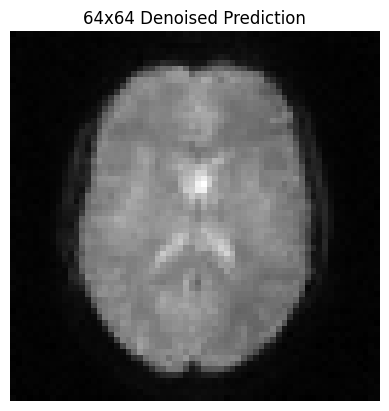

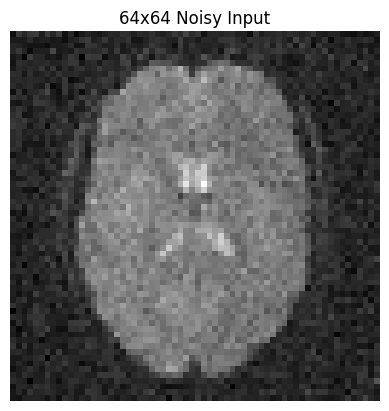

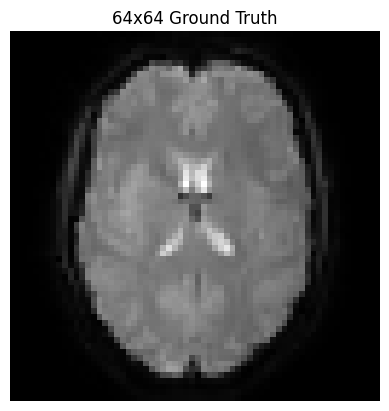

In [29]:
plt.imshow(Tensor.cpu(result)[0], cmap='gray')
plt.axis('off')
plt.title("64x64 Denoised Prediction")
plt.show()

plt.imshow(test_img[0][0], cmap='gray')
plt.axis('off')
plt.title("64x64 Noisy Input")
plt.show()

plt.imshow(gt_img[0][0], cmap='gray')
plt.axis('off')
plt.title("64x64 Ground Truth")
plt.show()

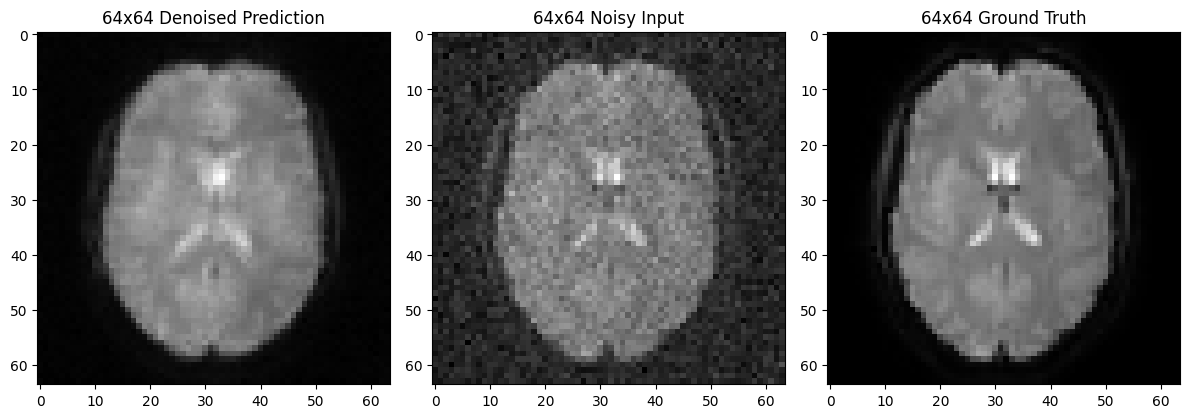

In [30]:
import matplotlib.pyplot as plt

# Create a single row with 3 columns for subplots
fig, axs = plt.subplots(1, 3, figsize=(12, 4))  # Adjust figsize as needed

# Denoised Prediction
axs[0].imshow(Tensor.cpu(result)[0], cmap='gray')
axs[0].set_title("64x64 Denoised Prediction")

# Noisy Input
axs[1].imshow(test_img[0][0], cmap='gray')
axs[1].set_title("64x64 Noisy Input")

# Ground Truth
axs[2].imshow(gt_img[0][0], cmap='gray')
axs[2].set_title("64x64 Ground Truth")

plt.tight_layout()
plt.show()


### Inference loop

In [31]:
# Import necessary libraries
import os
import numpy as np
import torch
import matplotlib.pyplot as plt
from IPython.display import display, clear_output

# --- Setup ---
# The path for the results is taken from the configuration
results_path = opt['path']['results']
os.makedirs(results_path, exist_ok=True)
print(f"Results will be saved in directory: {results_path}")

# Get the z-dimension size from the test data for coordinate calculation
try:
    test_data_shape = np.load(opt['datasets']['test']['noisy_data_paths'][0], mmap_mode='r').shape
    z_dim_size = test_data_shape[2]
except Exception as e:
    print(f"Could not load test data shape, using default z_dim_size=64. Error: {e}")
    z_dim_size = 64 # Fallback value

# Set the model to evaluation mode
diffusion.netG.eval()

# --- Initialization for batch processing and saving ---
total_slices = 100
all_denoised_slices = []
all_gt_slices = [] # <-- ADDED: List for ground truth slices
batch_counter = 1
SAVE_INTERVAL = 100 # Save after every 100 slices

print("\n--- Starting inference for all slices ---")

# --- Main processing loop ---
# Disable gradient calculation for inference
with torch.no_grad():
    for i, data in enumerate(test_loader):
        if i == total_slices:
            break
        # Update progress indicator on a single line
        print(f"Processing slice {i+1}/{total_slices}...", end='\r')

        # Get noisy image, ground truth, and index from the dataloader
        noisy_img = data['Noisy'].to("cuda")
        gt_img = data['GT'] # Keep ground truth on CPU for plotting and saving
        slice_idx = data['Index'][0].item()

        # load temporal features
        t_index = data["t_value"]
        z_index = data["z_value"]
        temp_features = []
        temp_features.append(temporal_features_1[t_index, z_index, :, :, :].copy())
                
        # stack temp_features to tensor after reshaping to match concatenation style
        temp_features = torch.from_numpy(np.array(temp_features)).to(data['GT'].device).float()

        # permute so that the last dimension becomes the second dimension
        shape = temp_features.shape
        temp_features = temp_features.permute(0, len(shape)-1, *range(1, len(shape)-1))

        # Perform the denoising process (inference)
        denoised_img_tensor = diffusion.inference(noisy_img, temp_features.to("cuda"))

        # Move the result tensor to the CPU for saving and plotting
        denoised_img_cpu = denoised_img_tensor.cpu()
        
        # Append results (as NumPy arrays) to their respective lists for batch saving
        all_denoised_slices.append(denoised_img_cpu.squeeze().numpy())
        all_gt_slices.append(gt_img.squeeze().numpy()) # <-- ADDED: Append GT slice
        

        # --- Periodic Saving Logic ---
        # Check if the save interval is reached or if it's the last slice
        is_last_slice = (i + 1) == total_slices
        if (i + 1) % SAVE_INTERVAL == 0 or is_last_slice:
            num_slices_in_batch = len(all_denoised_slices)
            if num_slices_in_batch > 0:
                print(f"\nSaving batch {batch_counter} with {num_slices_in_batch} slices...")
                
                # Define filenames for the batch
                start_slice_num = (batch_counter - 1) * SAVE_INTERVAL
                end_slice_num = start_slice_num + num_slices_in_batch
                denoised_filename = os.path.join(results_path, f"denoised_slices_{start_slice_num+1:05d}-{end_slice_num:05d}.npy")
                gt_filename = os.path.join(results_path, f"gt_slices_{start_slice_num+1:05d}-{end_slice_num:05d}.npy") # <-- ADDED: Filename for GT
                
                # Save the collected slices in separate NumPy files
                np.save(denoised_filename, np.array(all_denoised_slices))
                np.save(gt_filename, np.array(all_gt_slices)) # <-- ADDED: Save GT batch
                
                print(f"Batch successfully saved:\n  - {denoised_filename}\n  - {gt_filename}")
                
                # Clear the lists to free up memory
                all_denoised_slices.clear()
                all_gt_slices.clear() # <-- ADDED: Clear GT list
                batch_counter += 1

clear_output(wait=True)
print(f"--- Processing and saving of all {total_slices} slices completed. ---")

--- Processing and saving of all 100 slices completed. ---
